In [1]:
# -----------------------------
# Space Biology QA Pipeline
# -----------------------------

import os
import re
from dotenv import load_dotenv
from typing_extensions import List, TypedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

from langchain import hub
from langchain_core.documents import Document
from langchain.chat_models import init_chat_model
from qdrant_client import QdrantClient
from langchain_mistralai import MistralAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph

In [ ]:
# -----------------------------
# Load environment variables
# -----------------------------
load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# -----------------------------
# Initialize Qdrant Client and Embeddings
# -----------------------------
# collection_name = "biology_articles_v3"
ALL_DOCS_COLLECTION  = "biology_articles"
RESULTS_COLLECTION  = "task_proyects"
client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

embeddings = MistralAIEmbeddings(model="mistral-embed")

# Main collection (all articles)
store_all = QdrantVectorStore(
    client=client,
    collection_name=ALL_DOCS_COLLECTION,
    embedding=embeddings
)

# Secondary collection (results only)
store_results = QdrantVectorStore(
    client=client,
    collection_name=RESULTS_COLLECTION,
    embedding=embeddings
)

# -----------------------------
# Load Prompts and LLM
# -----------------------------
prompt_mission_architects = hub.pull("pruebanasa/mission_architects")
llm = init_chat_model("open-mixtral-8x7b", model_provider="mistralai")

In [ ]:
# -----------------------------
# Pipeline State
# -----------------------------
class State(TypedDict):
    question: str
    context: List[Document]
    summary: str
    answer: str

# -----------------------------
# Document Retrieval
# -----------------------------
def retrieve_architect(state: dict, k=10) -> dict:
    """
    Retrieves top-k relevant scientific papers and NASA projects related to
    space mission design, safety, and biological/engineering integration.
    Combines both Qdrant collections: all articles and project results.
    """
    print(f"[retrieve_architect] Searching for '{state['question']}' across collections...")

    # --- 1. Retrieve from both sources ---
    docs_bio = store_all.similarity_search(query=state["question"], k=k)
    docs_proj = store_results.similarity_search(query=state["question"], k=k)

    retrieved_docs = docs_bio + docs_proj

    if not retrieved_docs:
        print("[retrieve_architect] No relevant mission-related documents found.")
        return {"context": [], "summary": "No mission-related information found."}

    summary_blocks = []

    for i, doc in enumerate(retrieved_docs, start=1):
        meta = doc.metadata or {}

        # Identify if it's an article or project
        doc_type = "Scientific Article" if "title" in meta else "Project"

        # --- Extract common metadata ---
        title = meta.get("title") or meta.get("project_title", "Untitled")
        authors = meta.get("authors", "Unknown")
        publication_date = meta.get("publication_date", meta.get("start_date", "Unknown"))
        pmid = meta.get("pmid", "")
        pub_link = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/" if pmid else meta.get("pdf_download_link", "N/A")

        # --- Extract specialized metadata for mission relevance ---
        environment = meta.get("environment", "Not specified (e.g., microgravity, ISS, Mars analog, etc.)")
        mission_relevance = meta.get("mission_relevance", "")
        responsible_center = meta.get("project_information", {}).get("responsible_center", "Unknown")
        division = meta.get("division", "Unknown")
        key_findings = meta.get("key_findings", "") or meta.get("task_progress_and_bibliography", {}).get("task_progress", "")
        earth_benefits = meta.get("project_information", {}).get("research_impact/earth_benefits", "")
        implications = meta.get("implications", "No mission implications specified.")

        # --- Build structured text block ---
        info = f"""Document {i} ({doc_type})
Title: {title}
Authors/PI: {authors}
Date: {publication_date}
Division/Center: {division} / {responsible_center}
Environment: {environment}
Link: {pub_link}

Key Findings / Progress:
{key_findings or 'No findings available.'}

Mission Relevance:
{mission_relevance or implications}

Earth or Habitat Design Impact:
{earth_benefits or 'No direct impact described.'}

Content:
{doc.page_content.strip()}
"""
        summary_blocks.append(info.strip())
    # --- Combine summaries ---
    summary_text = "\n\n---\n\n".join(summary_blocks)
    print(f"[retrieve_architect] Retrieved {len(retrieved_docs)} relevant documents.")
    return {
        "context": retrieved_docs,
        "summary": summary_text
    }


# -----------------------------
# Generate Final Answer
# -----------------------------
def generate(state: State) -> State:
    """
    Generates a structured, technical answer to support lunar and Martian mission design
    based on biological and experimental research context.
    """
    context = state.get("summary", "")

    messages = prompt_mission_architects.invoke({
        "question": state["question"],
        "context": context
    })

    print("[generate] Sending data to LLM (Mission Architect Agent)...")
    response = llm.invoke(messages)
    answer = response.content.strip()

    state.update({
        "answer": answer,
    })
    print("[generate] LLM response generated successfully.")
    return state


# -----------------------------
# Pipeline Construction
# -----------------------------
graph_builder = StateGraph(State).add_sequence([
    retrieve_architect,   # Retrieve relevant mission data
    generate    # Generate analytical and technical summary
])

graph_builder.add_edge(START, "retrieve_architect")
graph = graph_builder.compile()

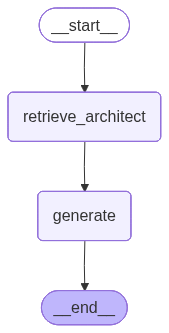

In [5]:
# -----------------------------
# Visualize pipeline (optional)
# -----------------------------
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# -----------------------------
# Example Queries
# -----------------------------
question_example_1 = "Based on current findings, what experimental designs could help predict how human microbiomes will evolve during multi-year missions to Mars?"
question_example_2 = "What are the main biological adaptations observed in plants exposed to microgravity and partial gravity environments?"

response = graph.invoke({"question": question_example_1})
print("\nFinal Answer:")
print(response["answer"])

[retrieve_architect] Searching for 'Based on current findings, what experimental designs could help predict how human microbiomes will evolve during multi-year missions to Mars?' across collections...
Document 1 (Scientific Article)
Title: Understanding the Complexities and Changes of the Astronaut Microbiome for Successful Long-Duration Space Missions
Authors/PI: Donatella Tesei, Anna Jewczynko, Anne M Lynch, Camilla Urbaniak
Date: 2022-03-28
Division/Center: Unknown / Unknown
Environment: Not specified (e.g., microgravity, ISS, Mars analog, etc.)
Link: https://pubmed.ncbi.nlm.nih.gov/35454986/

Key Findings / Progress:
No findings available.

Mission Relevance:
No mission implications specified.

Earth or Habitat Design Impact:
No direct impact described.

Content:
Alterations in the composition and functionality of the gut microbiome can be induced even by short-term space travel. Liu et al. (2020) reported shifts between dominant genera in the microbiome during space missions of 15